In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
titanic_test = pd.read_csv("/kaggle/input/titanic/test.csv")


In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer


In [4]:
titanic['FirstName'] = titanic['Name'].str.split(',|\\.',expand = True)[2] #expand set to True to return a df instead of series
titanic['FirstName'] = titanic['FirstName'].str.strip() #strip leading and trailing white spaces
titanic['LastName'] = titanic['Name'].str.split(',|\\.',expand = True)[0] #expand set to True to return a df instead of series
titanic['LastName'] = titanic['LastName'].str.strip()
titanic['title'] = titanic['Name'].str.split(',|\\.',expand = True)[1] #expand set to True to return a df instead of series
titanic['title'] = titanic['title'].str.strip()

status_map={'Capt':'Military',
            'Col':'Military',
            'Don':'Noble',
            'Dona':'Noble',
            'Dr':'Dr',
            'Jonkheer':'Noble',
            'Lady':'Noble',
            'Major':'Military',
            'Master':'Common',
            'Miss':'Common',
            'Mlle':'Common',
            'Mme':'Common',
            'Mr':'Common',
            'Mrs':'Common',
            'Ms':'Common',
            'Rev':'Clergy',
            'Sir':'Noble',
            'the Countess':'Noble',
            }

titanic['socialStatus'] = titanic['title'].map(status_map)

titanic['familyMembers'] = titanic['Parch'] + titanic['SibSp']

titanic['Age'] = titanic['Age'].fillna(titanic['Age'].mean())

########

titanic['deck'] = titanic['Cabin'].str.replace('[0-9]','').str.split(' ', expand=True)[0]
titanic['deck'] = titanic['deck'].fillna('NA') #cat
titanic['embarked'] = titanic['Embarked'].fillna('NA') #cat

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
titanic_test['FirstName'] = titanic_test['Name'].str.split(',|\\.',expand = True)[2] #expand set to True to return a df instead of series
titanic_test['FirstName'] = titanic_test['FirstName'].str.strip() #strip leading and trailing white spaces
titanic_test['LastName'] = titanic_test['Name'].str.split(',|\\.',expand = True)[0] #expand set to True to return a df instead of series
titanic_test['LastName'] =titanic_test['LastName'].str.strip()
titanic_test['title'] = titanic_test['Name'].str.split(',|\\.',expand = True)[1] #expand set to True to return a df instead of series
titanic_test['title'] = titanic_test['title'].str.strip()

status_map2={'Capt':'Military',
            'Col':'Military',
            'Don':'Noble',
            'Dona':'Noble',
            'Dr':'Dr',
            'Jonkheer':'Noble',
            'Lady':'Noble',
            'Major':'Military',
            'Master':'Common',
            'Miss':'Common',
            'Mlle':'Common',
            'Mme':'Common',
            'Mr':'Common',
            'Mrs':'Common',
            'Ms':'Common',
            'Rev':'Clergy',
            'Sir':'Noble',
            'the Countess':'Noble',
            }

titanic_test['socialStatus'] = titanic_test['title'].map(status_map2)

titanic_test['familyMembers'] = titanic_test['Parch'] + titanic_test['SibSp']

titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].mean())

########
titanic_test['deck'] = titanic_test['Cabin'].str.replace('[0-9]','').str.split(' ', expand=True)[0]
titanic_test['deck'] = titanic_test['deck'].fillna('NA') #cat
titanic_test['embarked'] = titanic_test['Embarked'].fillna('NA') #cat

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The default value of regex will change from True to False in a future version.


In [6]:
titanic_test.isnull().any()


PassengerId      False
Pclass           False
Name             False
Sex              False
Age              False
SibSp            False
Parch            False
Ticket           False
Fare              True
Cabin             True
Embarked         False
FirstName        False
LastName         False
title            False
socialStatus     False
familyMembers    False
deck             False
embarked         False
dtype: bool

In [7]:
features = ["Pclass", "Sex", "SibSp", "Age", "Parch", "socialStatus", "familyMembers", "deck", "Embarked" ]
X = titanic[features]
X_test = titanic_test[features]
y = titanic["Survived"]

features_num = ["Pclass", "Age", "SibSp", "Parch", "familyMembers"]
features_cat =["Sex", "socialStatus", "deck", "Embarked"]

In [8]:
transformer_num = make_pipeline(
        SimpleImputer(strategy="constant"),
        StandardScaler()
)

transformer_cat = make_pipeline(
     SimpleImputer(strategy="constant", fill_value="NA"),
     OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
      (transformer_num, features_num),
      (transformer_cat, features_cat),
)


In [9]:
X_train, X_valid, y_train, y_valid = \
   train_test_split(X,y,stratify=y, train_size=0.7)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]

In [10]:
from tensorflow import keras 
from tensorflow.keras import layers 

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(1,activation='sigmoid')
])


2021-09-13 22:45:17.197190: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 22:45:17.197328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-13 22:45:22.221816: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-13 22:45:22.225666: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 22:45:22.225709: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 22:45:22.225740: I tensorflow/stream_executor/cuda/cud

In [11]:
model.compile(
optimizer='adam',
loss='binary_crossentropy',
metrics=['binary_accuracy']
)

2021-09-13 22:45:22.735869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-13 22:45:22.749846: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/200
3/3 [==============================] - 2s 349ms/step - loss: 1.2077 - binary_accuracy: 0.5036 - val_loss: 0.6824 - val_binary_accuracy: 0.5746
Epoch 2/200
3/3 [==============================] - 0s 36ms/step - loss: 1.1855 - binary_accuracy: 0.4635 - val_loss: 0.6805 - val_binary_accuracy: 0.5709
Epoch 3/200
3/3 [==============================] - 0s 34ms/step - loss: 1.2683 - binary_accuracy: 0.4842 - val_loss: 0.6792 - val_binary_accuracy: 0.5821
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 1.1063 - binary_accuracy: 0.5263 - val_loss: 0.6778 - val_binary_accuracy: 0.6119
Epoch 5/200
3/3 [==============================] - 0s 34ms/step - loss: 1.0978 - binary_accuracy: 0.4964 - val_loss: 0.6749 - val_binary_accuracy: 0.6157
Epoch 6/200
3/3 [==============================] - 0s 34ms/step - loss: 1.0237 - binary_accuracy: 0.5436 - val_loss: 0.6712 - val_binary_accuracy: 0.6157
Epoch 7/200
3/3 [==============================] - 0s 34ms/step - loss: 1.0

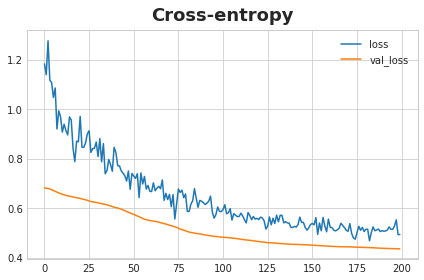

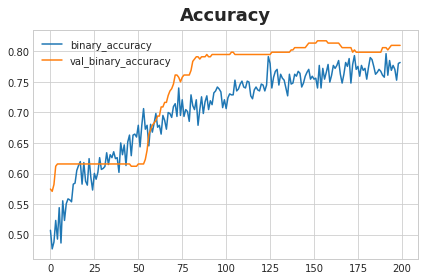

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
    callbacks=[early_stopping],
    
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [13]:
preds_test= model.predict(X_test)
preds_test = preds_test.round()

preds_better = np.concatenate(preds_test)

preds_full = preds_better.astype(int)
preds_full

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [14]:
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId, 'Survived': preds_full})
output.to_csv('my_submission.csv', index = False)